### Description of the Problem

A very simple e-commerce website has just 4 pages: home page, search page, payment page and payment confirmation page.

We need to investigate whether there is something wrong in the conversion funnel or, in general, if you can create hypotheses on how conversion rate could be improved.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'figure.figsize':(5, 2.2), 'legend.loc':'right'})

### 1. Read Data

In [88]:
user = pd.read_csv("../dataset/user_table.csv")
home_page = pd.read_csv("../dataset/home_page_table.csv")
search_page = pd.read_csv("../dataset/search_page_table.csv")
payment_page = pd.read_csv("../dataset/payment_page_table.csv")
payment_confirmation = pd.read_csv("../dataset/payment_confirmation_table.csv")

### 2. Data Exploration Analysis

In [10]:
for df in [user, home_page, search_page, 
           payment_page, payment_confirmation]:
    print("==================================")
    print(df.head(2))
    print(df.info())

   user_id        date   device     sex
0   450007  2015-02-28  Desktop  Female
1   756838  2015-01-13  Desktop    Male
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  90400 non-null  int64 
 1   date     90400 non-null  object
 2   device   90400 non-null  object
 3   sex      90400 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None
   user_id       page
0   313593  home_page
1   468315  home_page
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  90400 non-null  int64 
 1   page     90400 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB
None
   user_id         page
0    15866  search_page
1   347058  search_page
<class 'pandas.core.frame.DataFrame'>
RangeInd

### 3. Tasks

#### Part 1. Show the full picture of funnel conversion rate for both desktop and mobile

For each device type, I will calculate the conversion rate for different genders and different dates, between different layer of the user funnel.

<IPython.core.display.Javascript object>


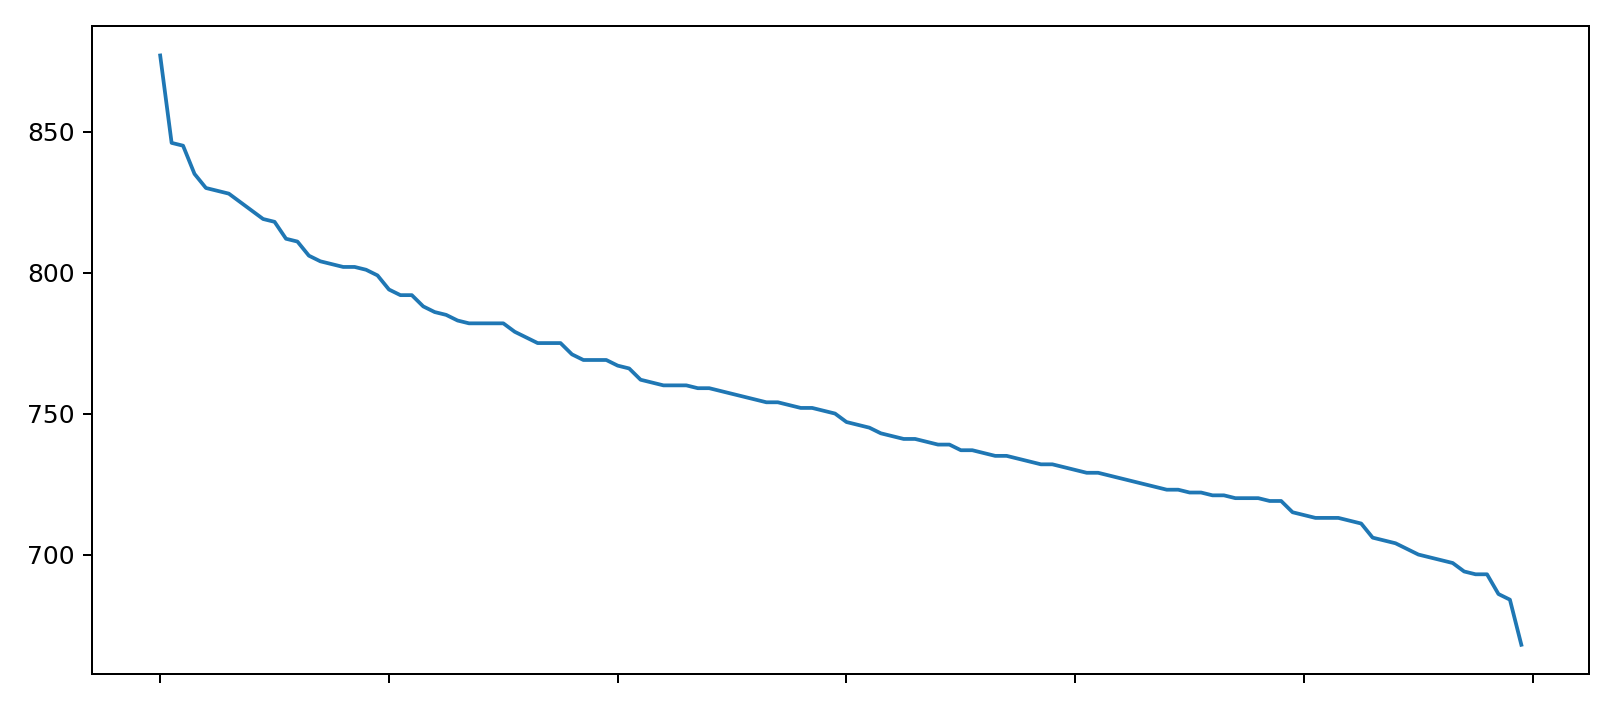

<AxesSubplot:>

In [32]:
%matplotlib notebook
user.date.value_counts().plot()

In [36]:
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


<IPython.core.display.Javascript object>


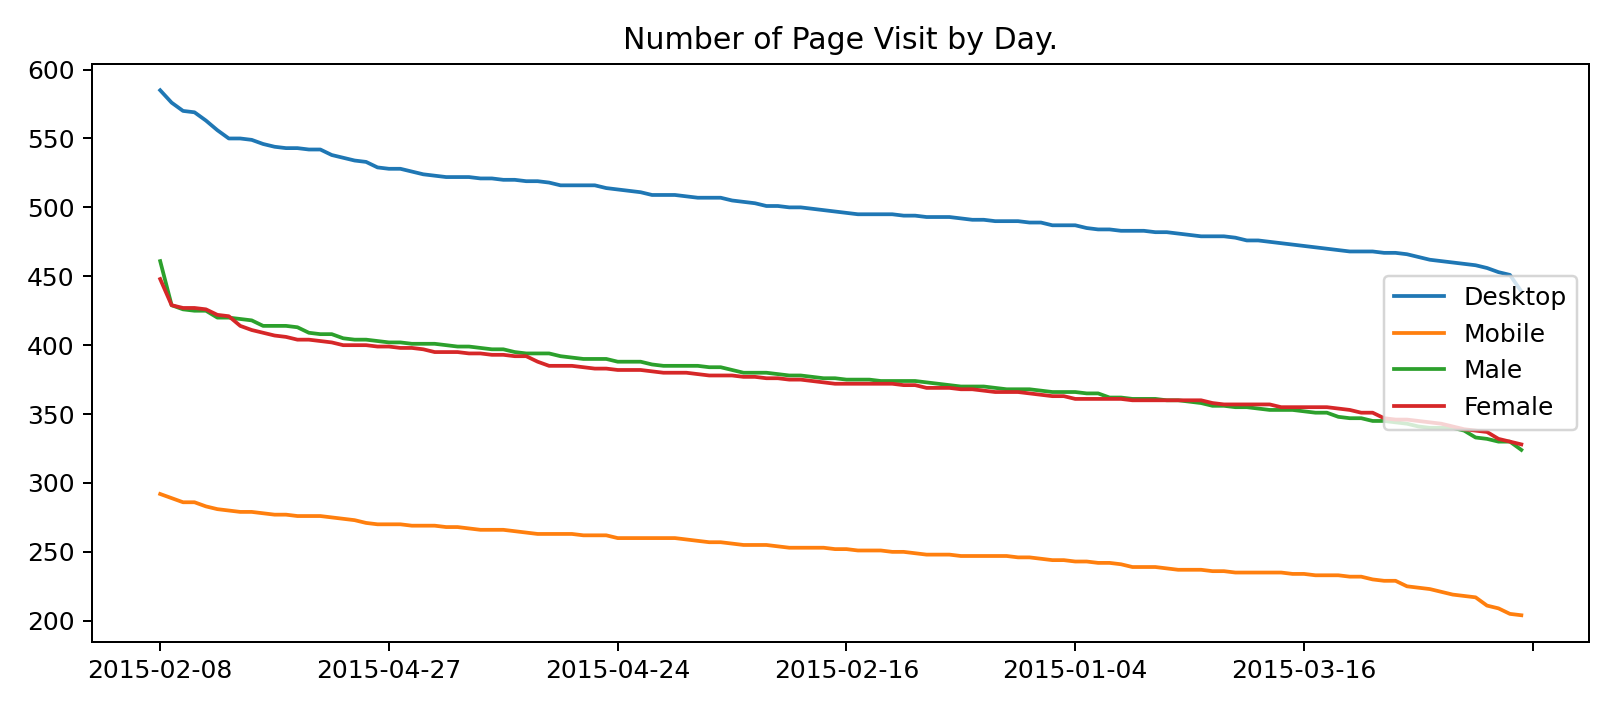

Text(0.5, 1.0, 'Number of Page Visit by Day.')

In [48]:
%matplotlib notebook
_ = user[user.device=='Desktop'].date.value_counts().plot(label='Desktop')
_ = user[user.device=='Mobile'].date.value_counts().plot(label='Mobile')
_ = user[user.sex=='Male'].date.value_counts().plot(label='Male')
_ = user[user.sex=='Female'].date.value_counts().plot(label='Female')
plt.title("Number of Page Visit by Day.")
plt.legend()

It is found we have less new users with time going.

In [23]:
user.device.value_counts()

Desktop    60200
Mobile     30200
Name: device, dtype: int64

In [22]:
user.sex.value_counts()

Male      45325
Female    45075
Name: sex, dtype: int64

In [21]:
user.groupby("device").apply(lambda df: df.sex.value_counts())

sex,Male,Female
device,,
Desktop,30203,29997
Mobile,15122,15078


It is found 1/3 of the new users come to the site through mobile, and 2/3 come to the site through desktop. And similar number of usuers come to the site given each of the device type.

In [89]:
# check the number of unique search page visitors
level2_cnt = pd.merge(home_page, search_page, on="user_id", how="inner").user_id.nunique()
print(level2_cnt)
print(search_page.user_id.nunique())

45200
45200


In [90]:
# check the number of unique payment page visitors
level3_cnt = pd.merge(search_page, payment_page, on="user_id", how="inner").user_id.nunique()
print(level3_cnt)
print(payment_page.user_id.nunique())

6030
6030


In [91]:
# check the number of unique payment confirmations 
level4_cnt = pd.merge(payment_page, payment_confirmation, on="user_id", how="inner").user_id.nunique()
print(level4_cnt)
print(payment_confirmation.user_id.nunique())

452
452


In [92]:
# user, home_page (level 1), search_page (level 2) , payment_page (level 3), payment_confirmation (level4)

In [93]:
# check conversion rate by device type
for df in [user, home_page, search_page, payment_page, payment_confirmation]:
    df.set_index("user_id", inplace=True)
    if "page" in df.columns:
        df.columns = [df.iloc[0,0]]

In [94]:
dfall = pd.concat([user, home_page, search_page, payment_page, payment_confirmation], axis=1)
dfall.head()

,date,device,sex,home_page,search_page,payment_page,payment_confirmation_page
user_id,,,,,,,
17,2015-04-21,Desktop,Male,home_page,search_page,NaN,NaN
28,2015-04-29,Desktop,Male,home_page,NaN,NaN,NaN
37,2015-02-21,Mobile,Male,home_page,search_page,NaN,NaN
38,2015-03-23,Mobile,Female,home_page,search_page,payment_page,NaN
55,2015-02-01,Desktop,Male,home_page,NaN,NaN,NaN


In [95]:
# overall conversion rates (CVR)
def calc_conversions(df):
    level1 = df[~df.home_page.isnull()].shape[0]
    level2 = df[~df.search_page.isnull()].shape[0]
    level3 = df[~df.payment_page.isnull()].shape[0]
    level4 = df[~df.payment_confirmation_page.isnull()].shape[0]
    d = {}
    d["search_page_CVR"] = level2/level1
    d["payment_page_CVR"] = level3/level2
    d["payment_confirmation_page_CVR"] = level4/level3
    
    return pd.Series(d)
calc_conversions(dfall)

search_page_CVR                  0.500000
payment_page_CVR                 0.133407
payment_confirmation_page_CVR    0.074959
dtype: float64

In [97]:
# conversion rates by segments (defined by device-sex combinations)
CRVs = dfall.groupby(["device", "sex"]).apply(calc_conversions)
CRVs

search_page_CVR  payment_page_CVR  \
device  sex                                         
Desktop Female         0.503084          0.101385   
        Male           0.496937          0.098608   
Mobile  Female         0.503051          0.206987   
        Male           0.496958          0.192947   

                payment_confirmation_page_CVR  
device  sex                                    
Desktop Female                       0.048366  
        Male                         0.051351  
Mobile  Female                       0.106369  
        Male                         0.093103

In [101]:
CRVs.iloc[0,:]-CRVs.iloc[1,:]

search_page_CVR                  0.006146
payment_page_CVR                 0.002777
payment_confirmation_page_CVR   -0.002985
dtype: float64

In [102]:
CRVs.iloc[2,:]-CRVs.iloc[3,:]

search_page_CVR                  0.006093
payment_page_CVR                 0.014040
payment_confirmation_page_CVR    0.013266
dtype: float64

* It is found females have slightly (less than 1%) higher conversion rate, and the only exception is with Desktop on payment_confirmation_page_CVR. In other words, the CRVs are similar between males and femails.
* Given different device type, the search_page_CVR looks similar. However, both payment page conversion	and payment confirmation page conversion show around twice the CVR given Mobile device type, as compared to the CVRs of Desktop. 

In below is the bar charts for ease of comparison.

<IPython.core.display.Javascript object>


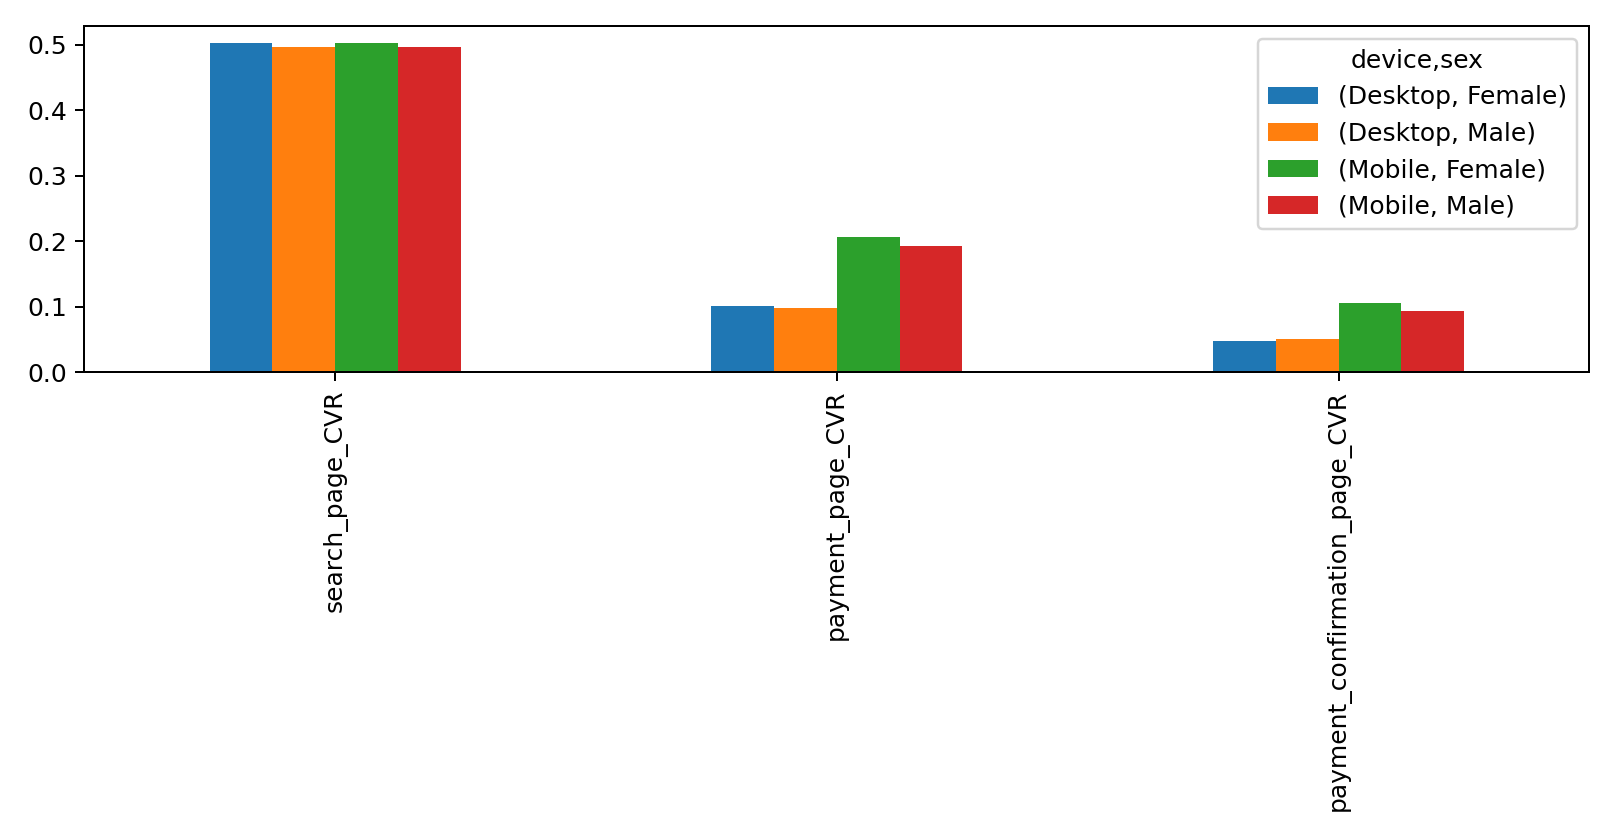

<AxesSubplot:>

In [117]:
CRVs.T.plot(kind="bar", figsize=(5,2.6))

#### Part 2. Some insights on what the product team should focus on in order to improve conversion rate as well as any anything you might discover that could help improve conversion rate.

The the product team need to focust on improving the desktop search and payment tool. 

* first, we should first check if the payment page and payment confirmation page can be rendered as expected for all desktop browsers. Is there any technical issues with particular desktop browsers? 

* second, it is very important to improve the layout as well as the call to action (CTA) button on desktop search page and payment page, whose task is to lead the user click into the next page. This is because on desktop, user can multi-task on desktop and their attention can be distracted by other tasks or even competitor web apps. 

* third, we should improve the desktop payment page user experience, especially the efficiency of filling the payment information  and the efficiency of payent method authentication. 

* last, for both mobile and desktop, we can think about if more payment method can be made available on Desktop. 